<a href="https://colab.research.google.com/github/AnnyBianchi/Protezione-Civile/blob/main/SantiniMichele_5AM__Progetto_IA_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [9]:

# Caricamento del dataset
dataset, info = tfds.load('oxford_iiit_pet', split=['train', 'test'], with_info=True, as_supervised=True)


In [10]:
# Preprocessing e Data Augmentation
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = dataset[0].map(preprocess).cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = dataset[1].map(preprocess).cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)


In [11]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])


In [12]:
# Definizione dell'architettura del modello (Transfer Learning con ResNet50)
base_model = ResNet50(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(37, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [17]:
# Addestramento del modello
history = model.fit(train_ds, epochs=25, validation_data=test_ds)


115/115 [==============================] - 526s 5s/step - loss: 3.6115 - accuracy: 0.0236 - val_loss: 3.6109 - val_accuracy: 0.0273


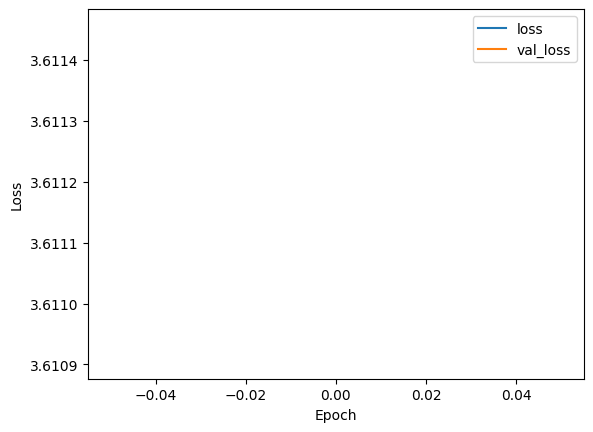

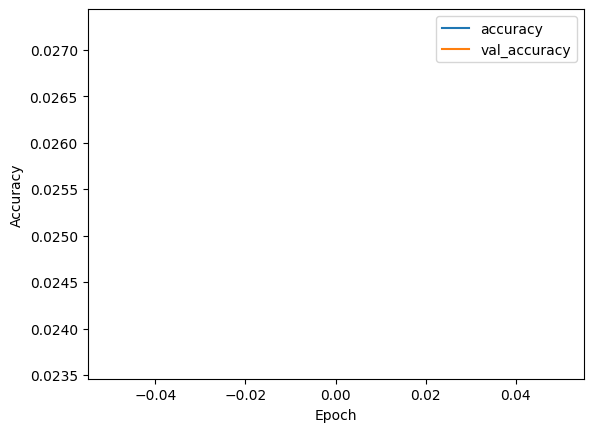

In [20]:
# Visualizzazione delle curve di loss e accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


4/4 [==============================] - 17s 3s/step


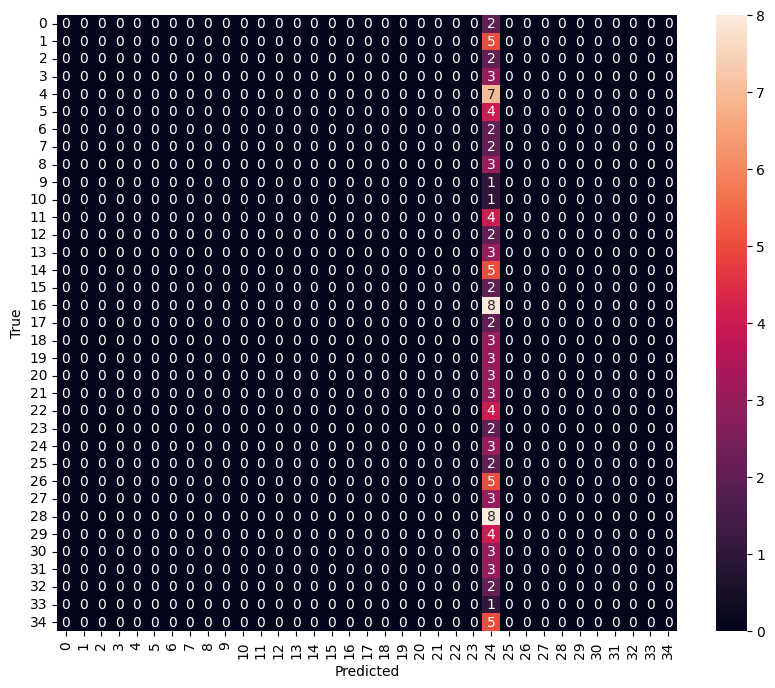

In [21]:
# Matrice di confusione
test_images, test_labels = next(iter(test_ds.unbatch().batch(len(test_ds))))
test_pred = model.predict(test_images)
test_pred_classes = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_labels, test_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()